In [1]:
import spotiphy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import importlib as imp
import spotiphy
import anndata as ad
import umap
imp.reload(spotiphy)

<module 'spotiphy' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\__init__.py'>

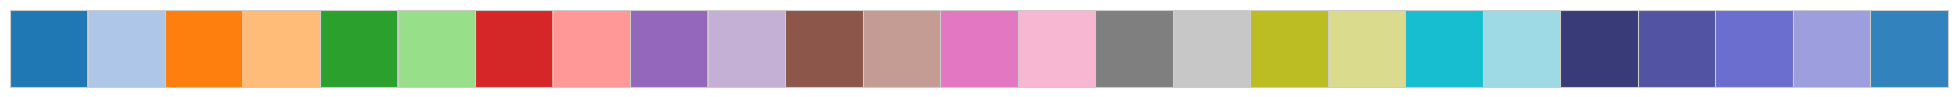

In [2]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
cmap3 = plt.get_cmap("tab20c")
colors1 = cmap1.colors
colors2 = cmap2.colors
colors3 = cmap3.colors
contrast_palette = sns.color_palette(list(colors1) + list(colors2[:4]) + list(colors3[:1]))
del cmap1, cmap2, cmap3, colors1, colors2, colors3
sns.palplot(contrast_palette)

In [3]:
%%time
# adata_sc_files = ["F:/Ziqian Zheng/Spatial omics/Public dataset/scRNA/scRNA.h5ad",
#                   "F:/Ziqian Zheng/Spotiphy_data/SCRNA/sum_43plus_anno.h5ad",]
# adata_sc = sc.read_h5ad(adata_sc_files[1])
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ST/Sample221/outs")
# adata_st = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/Simulated ST/Simulated_ST_221_1.h5ad")
adata_st.var_names_make_unique()
results_folder = 'results/221_43plus/'
key_type = 'majortype'
cell_proportion = np.load(results_folder+'proportion.npy')

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: total: 1.78 s
Wall time: 1.79 s


In [4]:
%%time
# adata_st_decomposed = spotiphy.deconvolution.decomposition(adata_st, adata_sc, key_type, cell_proportion, save=True,
#                                out_dir=results_folder, threshold=0.1, spot_location=adata_st.obsm['spatial'])
adata_st_decomposed = sc.read_h5ad(results_folder+'ST_decomposition.h5ad')
adata_st_decomposed.uns['spatial'] = adata_st.uns['spatial']

CPU times: total: 297 ms
Wall time: 586 ms


In [6]:
adata_st_decomposed.obs['cell_type'].value_counts()

cell_type
GABAergic          3361
Microglia          2692
Macrophage         2208
DAM                 581
Neutrophil          295
TCell               280
Oligodendrocyte     260
Ependymal           203
Fibroblast          101
BCell                43
Glutamatergic        24
OPC                   4
RadialGlia            2
NSC                   1
Name: count, dtype: int64

In [17]:
# cluster_df = pd.read_excel('results/221_43plus/meta.data.xlsx', header=0)
# adata_st_decomposed.obs['seurat_clusters'] =  cluster_df['seurat_clusters'].values
# seurat_clusters = adata_st_decomposed.obs.groupby('seurat_clusters')['cell_type'].value_counts().unstack().fillna(0)
# seurat_clusters.to_csv(results_folder+'seurat_cluster_purity.csv')

In [23]:
cluster_df = pd.read_csv('results/221_43plus/clustering_UMAP_euclidean_20_1.0.txt', header=0, delimiter='\t')
adata_st_decomposed.obs['mica_clusters'] =  cluster_df['label'].values
mica_clusters = adata_st_decomposed.obs.groupby('mica_clusters')['cell_type'].value_counts().unstack().fillna(0)
mica_clusters.to_csv(results_folder+'mica_cluster_purity.csv')

In [6]:
%%time
sc.pp.normalize_total(adata_st_decomposed, target_sum=1e6)
sc.pp.log1p(adata_st_decomposed)
adata_st_decomposed.raw = adata_st_decomposed

CPU times: total: 1.08 s
Wall time: 1.07 s


scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


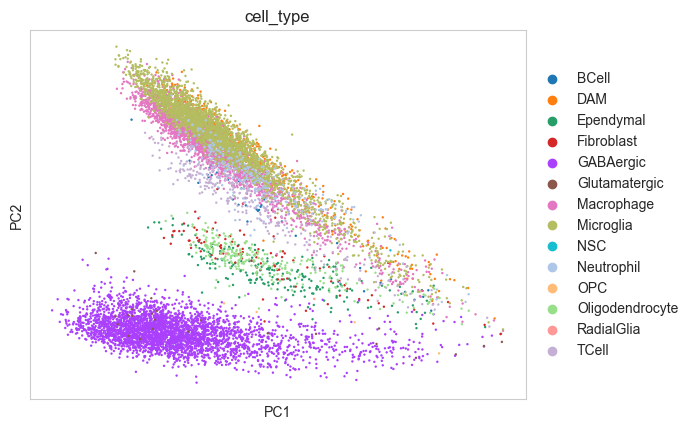

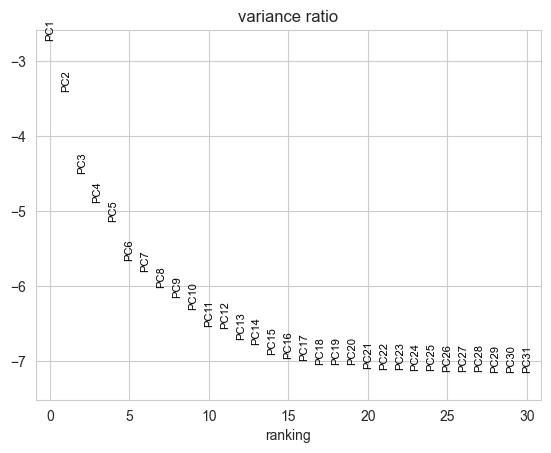

In [8]:
sc.tl.pca(adata_st_decomposed, svd_solver='arpack')
sc.pl.pca(adata_st_decomposed, color='cell_type')
sc.pl.pca_variance_ratio(adata_st_decomposed, log=True)

scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


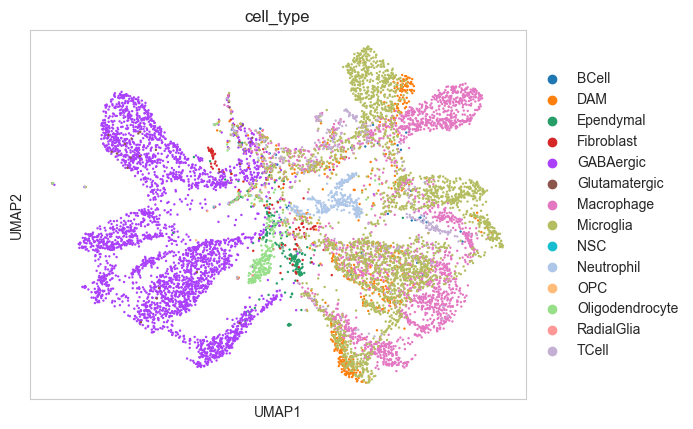

In [9]:
sc.pp.neighbors(adata_st_decomposed, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_st_decomposed)
sc.pl.umap(adata_st_decomposed, color='cell_type')

scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


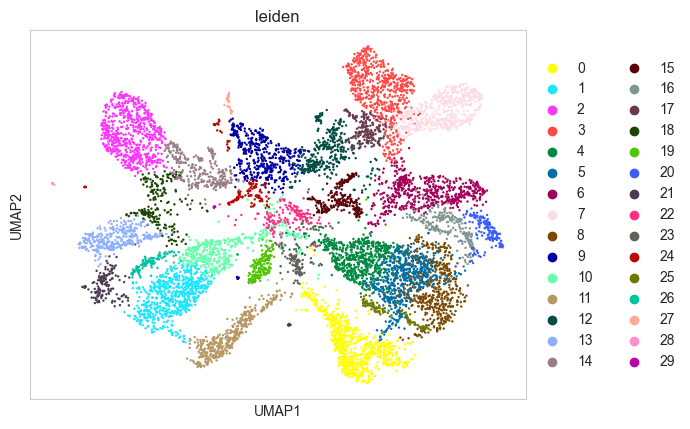

In [10]:
sc.tl.leiden(adata_st_decomposed)
sc.pl.umap(adata_st_decomposed, color='leiden')

In [15]:
cluster_df = adata_st_decomposed.obs.groupby('leiden')['cell_type'].value_counts().unstack()
cluster_df

In [69]:
%%time
adata_st_decomposed_DAM = adata_st_decomposed[adata_st_decomposed.obs['cell_type']=='DAM']
sc.tl.pca(adata_st_decomposed_DAM, svd_solver='arpack')
sc.pp.neighbors(adata_st_decomposed_DAM, n_neighbors=5, n_pcs=30)
sc.tl.umap(adata_st_decomposed_DAM)

CPU times: total: 9.41 s
Wall time: 2.44 s


scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


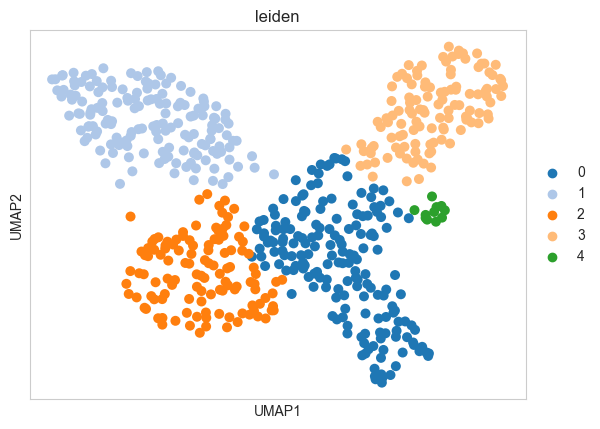

In [72]:
sc.tl.leiden(adata_st_decomposed_DAM, resolution=0.3, random_state=-1)
sc.pl.umap(adata_st_decomposed_DAM, color='leiden', palette=contrast_palette)

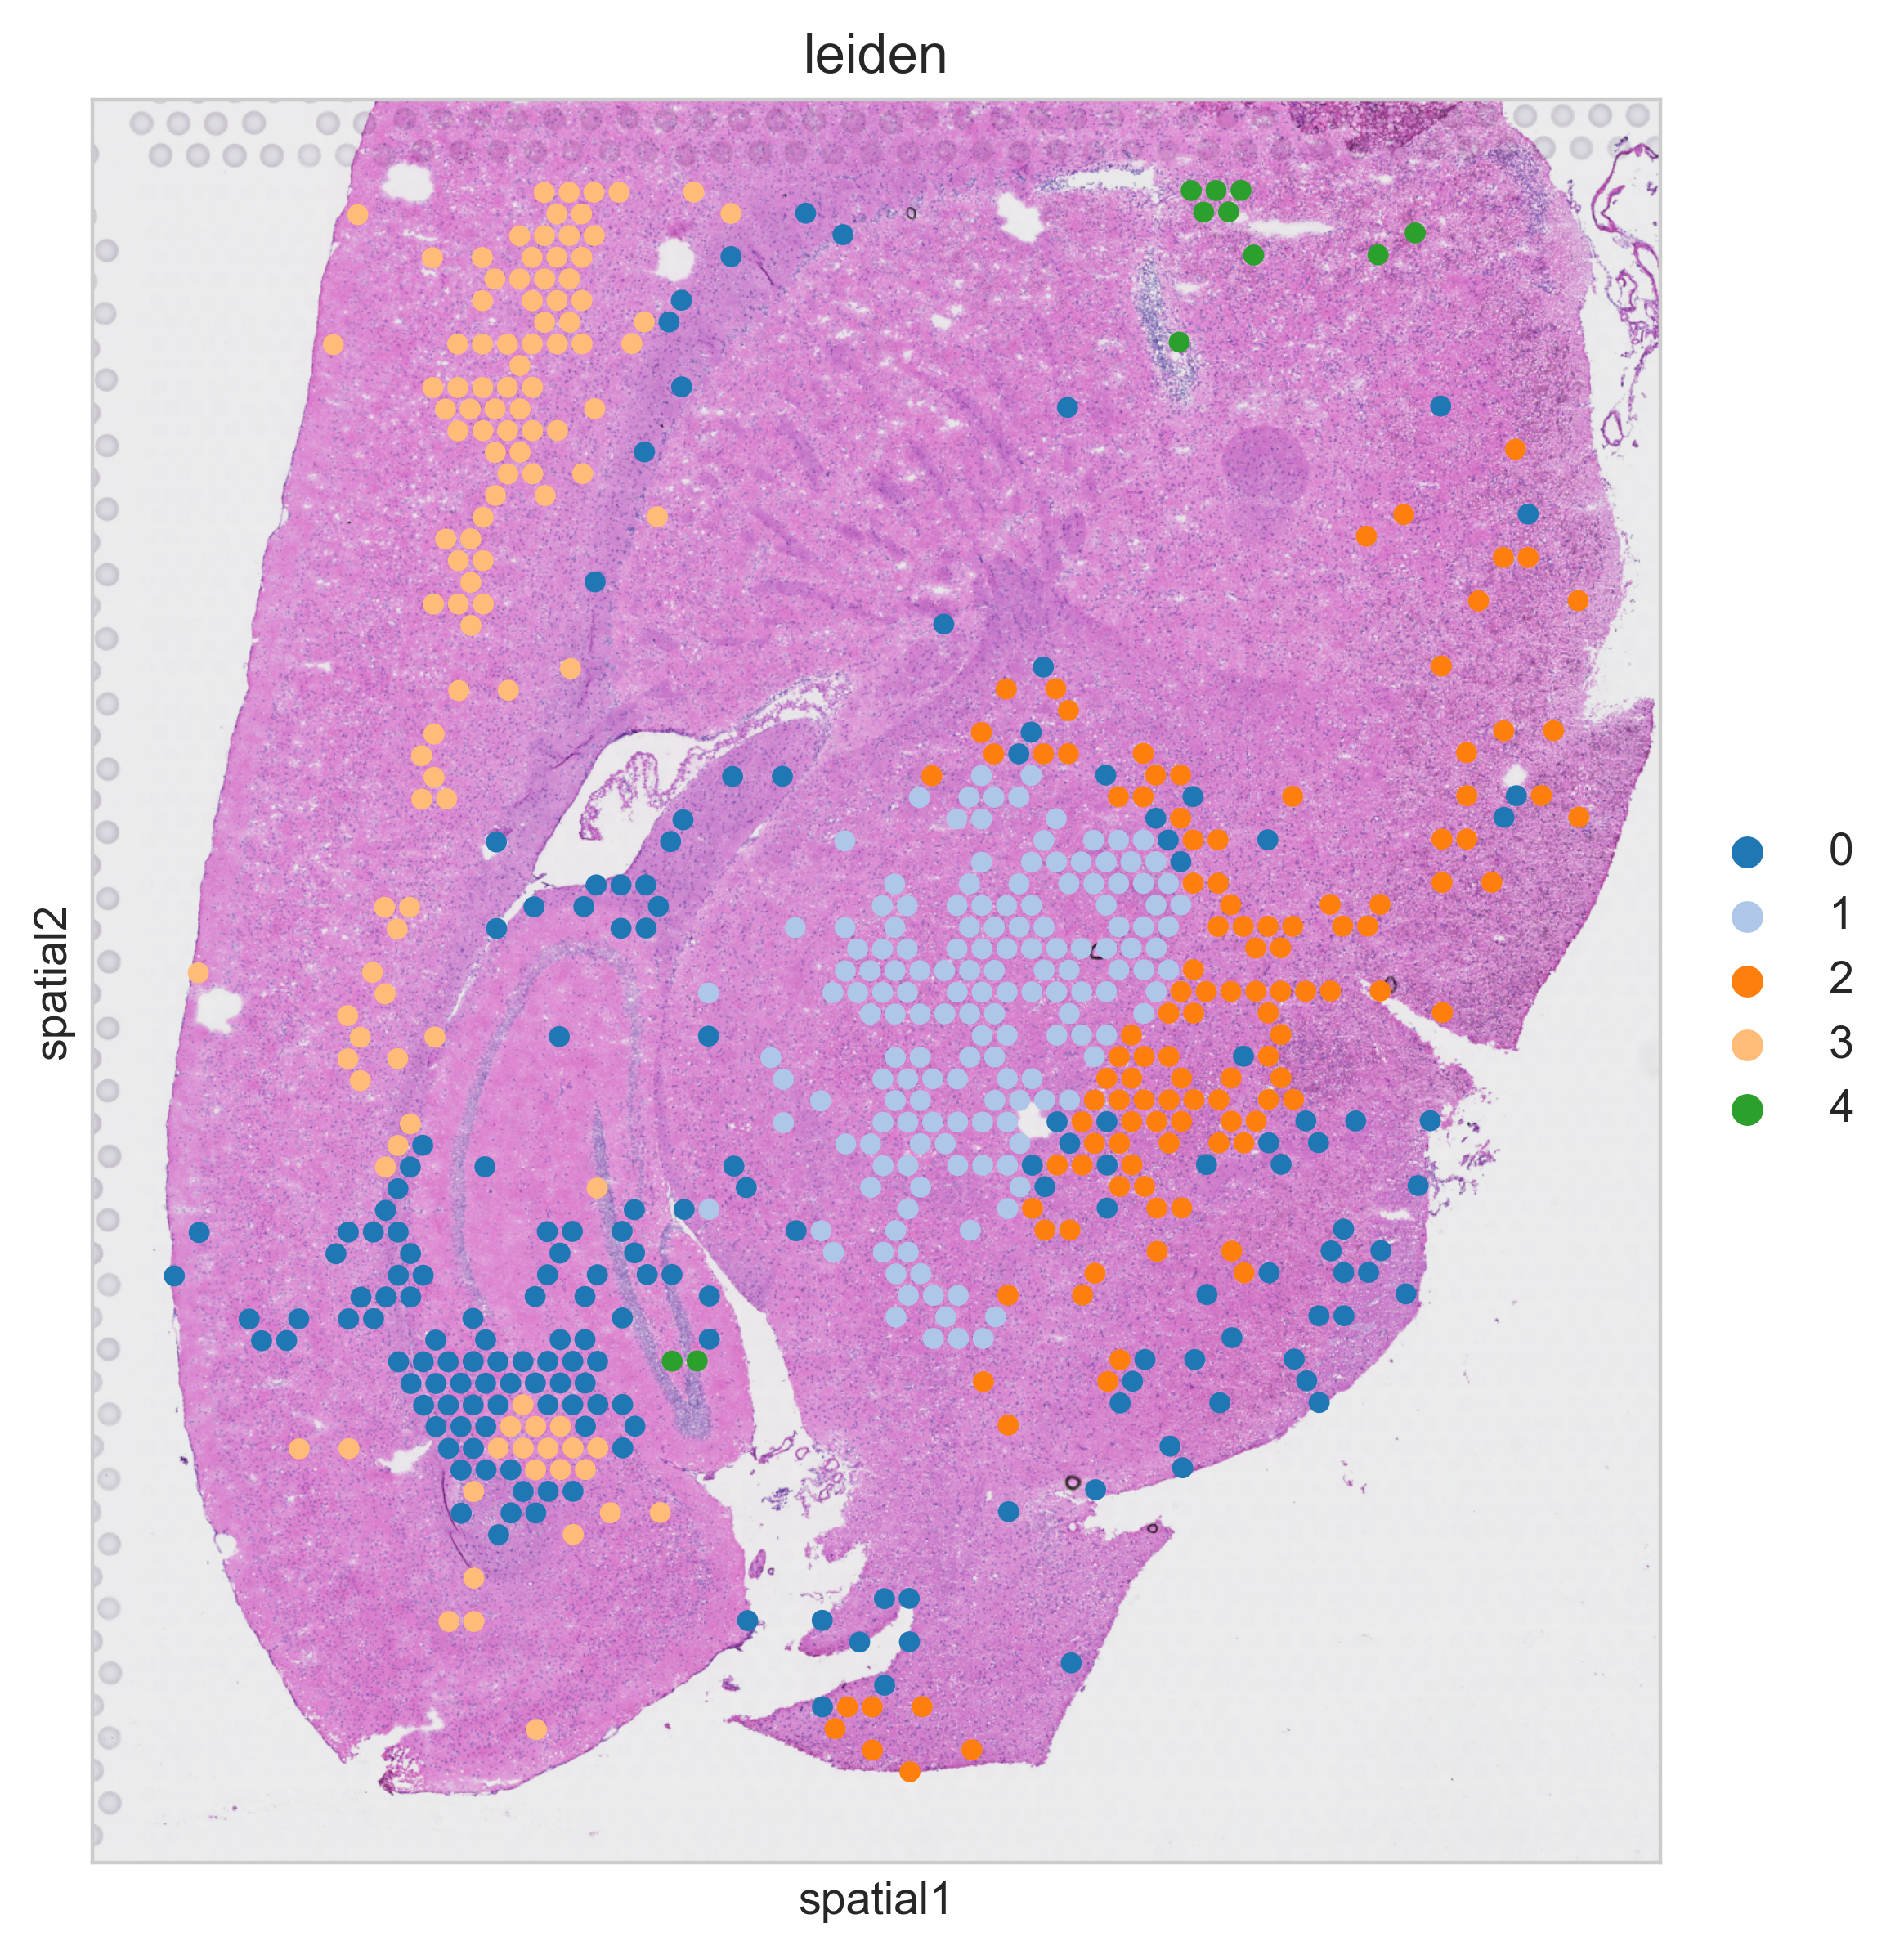

In [78]:
adata_st_decomposed_DAM.obs['-location_y'] = adata_st_decomposed_DAM.obs['location_y']*(-1)
adata_st_decomposed_DAM.obsm['spatial'] = adata_st_decomposed_DAM.obs[['location_x', 'location_y']].values
with mpl.rc_context({'figure.figsize': [7, 7], 'figure.dpi': 400}):
    sc.pl.spatial(adata_st_decomposed_DAM, color='leiden', img_key='hires', size=1.3)
    # sc.pl.scatter(adata_st_decomposed_DAM, x='location_x', y='-location_y', color='leiden', palette=contrast_palette)

In [41]:
adata_st_decomposed_DAM.obs

cell_type  location_x  location_y leiden
43        DAM        2692        4968      1
44        DAM        6063        4762      4
45        DAM        5392        5742      3
46        DAM        2694        5750      6
47        DAM        6909        5640      0
..        ...         ...         ...    ...
619       DAM        2921        6532      5
620       DAM        6173        3980      2
621       DAM        5950        4372      4
622       DAM        3316        7216      0
623       DAM        3143        5749      5

[581 rows x 4 columns]